안정적인 전략은 이미 all seasons, permanent portfolio 등 정적인 자산배분 전략들에서 많이 했으니 조금 더 거칠지만 수익성이 더 좋은 동적 자산배분 전략도 알아볼 것입니다. 6월 3일에 올린 섹터 로테이션 전략도 이런 방향을 같이 합니다. VAA (Vigilant Asset Allocation) 전략은 꽤 공격적인 동적 자산배분 (모멘텀) 전략입니다. 공격 자산 또는 방어 자산으로 구성된 유니버스에서 매월 포트폴리오의 100%를 단일 자산에 할당합니다. VAA의 모멘텀 측정은 최근일수록 더 가중치를 크게 줍니다. 그러므로, VAA는 시장 변화에 더 빠르게 대응할 수 있지만, 거래 횟수가 많아질 수 있습니다.

VAA 전략 논문의 저자는 글로벌 기준으로 12개 공격 자산(S&P 500, Russell 2000, NASDAQ 100, Europe Stock, Japan Stock, US REITs, Commodities, Gold, Long Term Treasury, Investment Grade Corporate Bond, High Yield Bond)과 3개 방어 자산(1-3 Year Treasury, 7-10 Year Treasury, Investment Grade Corporate Bond)을 사용하는 전략도 제시합니다. 그러나, 전략의 골격은 같고 아래에서 테스트하는 공격 자산 4개, 방어 자산 3개 조합이 더 간단하니 그렇게 합니다.

In [1]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime, timedelta
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
import seaborn
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


사용되는 공격 자산은 SPY (S&P 500), EFA (MSCI EAFE), EEM (Emerging), AGG (Aggregate US Bond)이고, 방어 자산은 LQD (Investment Grade Corporate Bond), IEF (US 7-10 Year Treausry), SHY (US 1-3 Year Treasury)입니다. 실제 거래를 할 때는 ETF를 사용할 것이니 유동성도 풍부하고 사용하기도 쉬운 ETF들로 테스트합니다.

In [3]:
# 공격 자산: SPY (S&P 500), EFA (MSCI EAFE), EEM (Emerging), AGG (Aggregate US Bond) 
# 방어 자산: LQD (Investment Grade Corporate Bond), IEF (US 7-10 Year Treausry), SHY (US 1-3 Year Treasury)

# AGG starts: 2003-09-29
start = datetime(2003,10,1)
end = datetime(2021,5,31)

tickers = ['SPY','EFA','EEM','AGG','LQD','SHY','IEF']

def get_price_data(tickers):
    df_asset = pd.DataFrame(columns=tickers)
    
    for ticker in tickers:
        df_asset[ticker] = pdr.get_data_yahoo(ticker, start, end)['Adj Close']  
         
    return df_asset

In [4]:
df_asset = get_price_data(tickers)
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF
Date,,,,,,,
2003-09-30,70.701805,23.791895,10.897561,58.132175,53.139111,61.204376,52.677532
2003-10-01,72.208504,24.572763,11.183770,58.103828,53.291977,61.213921,52.911316
2003-10-02,72.470215,24.534121,11.344110,58.013260,53.087158,61.213921,52.721107
2003-10-03,73.135155,24.892019,11.456349,57.594452,52.348888,61.058487,51.990978
2003-10-06,73.467606,25.152304,11.500443,57.679333,52.401260,61.102852,52.144318
...,...,...,...,...,...,...,...
2021-05-24,419.170013,79.433777,53.346413,114.283142,131.323257,86.288010,114.241051
2021-05-25,418.239990,79.453514,53.874104,114.562744,131.812302,86.288010,114.660759
2021-05-26,419.070007,79.404182,54.272358,114.522797,131.742432,86.307999,114.530853


모멘텀을 특이한 방식으로 측정합니다. 섹터 로테이션에서는 12개월 전과 비교했는데, VAA 전략은 1, 3, 6, 12개월 전과 비교하면서 최근일수록 가중치를 크게 줍니다. 365일, 180일, 90일, 30일 전이 거래일이 아닐 수 있으니 그 근처 5일을 가져오고 그 중 가장 최근 값을 취합니다. 

In [5]:
def get_momentum(x):
    temp = [0 for _ in range(len(x.index))]
    momentum = pd.Series(temp, index=x.index)
    
    try:
        before_1m = df_asset[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1]
        before_3m = df_asset[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1]
        before_6m = df_asset[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1]
        before_12m = df_asset[x.name-timedelta(days=370):x.name-timedelta(days=365)].iloc[-1]
        momentum = (x/before_1m - 1) * 12 + (x/before_3m - 1) * 4 + (x/before_6m - 1) * 2 + (x/before_12m - 1) * 1
        
    except:
        pass
    
    return momentum

In [6]:
momentum_col = [col + '_m' for col in df_asset.columns]
df_asset[momentum_col] = df_asset.apply(lambda x: get_momentum(x), axis=1)
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,AGG_m,LQD_m,SHY_m,IEF_m
Date,,,,,,,,,,,,,,
2003-09-30,70.701805,23.791895,10.897561,58.132175,53.139111,61.204376,52.677532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-10-01,72.208504,24.572763,11.183770,58.103828,53.291977,61.213921,52.911316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-10-02,72.470215,24.534121,11.344110,58.013260,53.087158,61.213921,52.721107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-10-03,73.135155,24.892019,11.456349,57.594452,52.348888,61.058487,51.990978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-10-06,73.467606,25.152304,11.500443,57.679333,52.401260,61.102852,52.144318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,419.170013,79.433777,53.346413,114.283142,131.323257,86.288010,114.241051,1.181711,1.181693,0.269094,-0.081027,-0.017866,0.009609,-0.220735
2021-05-25,418.239990,79.453514,53.874104,114.562744,131.812302,86.288010,114.660759,1.089724,1.173409,0.484626,-0.033357,0.046774,0.010535,-0.146308
2021-05-26,419.070007,79.404182,54.272358,114.522797,131.742432,86.307999,114.530853,1.186438,1.168760,0.651034,0.005785,0.101121,0.023759,-0.104925


12개월 모멘텀 때문에 앞쪽 1년은 사용 못 합니다. 그러니 제거하고 2004년 10월 1일부터로 보겠습니다.

In [8]:
df_asset = df_asset.loc[df_asset.index >= '2004-10-01']
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,AGG_m,LQD_m,SHY_m,IEF_m
Date,,,,,,,,,,,,,,
2004-10-01,81.690331,29.656200,14.167426,59.895668,56.063477,61.976223,54.856636,0.471689,0.678517,1.598204,0.139440,0.230054,0.016283,0.183581
2004-10-04,81.826904,29.701622,14.409195,59.913223,56.028065,61.983799,54.875950,0.442071,0.799115,1.946168,0.221193,0.388868,0.056296,0.312958
2004-10-05,81.870026,29.718155,14.302814,59.907383,56.260727,61.991364,54.875950,0.439779,0.753844,1.727194,0.219028,0.462843,0.057389,0.311708
2004-10-06,82.430656,29.829670,14.468021,59.796021,56.098888,61.938400,54.695820,0.597324,0.856004,2.032849,0.182424,0.408178,0.040617,0.253906
2004-10-07,81.546562,29.625223,14.344717,59.796021,55.977478,61.915657,54.599323,0.299342,0.519007,1.720499,0.193212,0.292658,0.033626,0.204132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,419.170013,79.433777,53.346413,114.283142,131.323257,86.288010,114.241051,1.181711,1.181693,0.269094,-0.081027,-0.017866,0.009609,-0.220735
2021-05-25,418.239990,79.453514,53.874104,114.562744,131.812302,86.288010,114.660759,1.089724,1.173409,0.484626,-0.033357,0.046774,0.010535,-0.146308
2021-05-26,419.070007,79.404182,54.272358,114.522797,131.742432,86.307999,114.530853,1.186438,1.168760,0.651034,0.005785,0.101121,0.023759,-0.104925


월말 리밸런싱으로 할 것이니 월말 데이터만 남깁니다.

In [9]:
df_asset = df_asset.resample(rule='M').last()
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,AGG_m,LQD_m,SHY_m,IEF_m
Date,,,,,,,,,,,,,,
2004-10-31,81.366859,30.224117,14.297174,60.522938,56.979008,62.203373,55.622078,0.395783,1.064295,1.396009,0.379025,0.493958,0.121996,0.460091
2004-11-30,84.989098,32.062145,15.719555,60.075584,56.283878,61.845367,54.521965,1.043374,1.672985,2.762306,0.046613,0.056559,-0.052612,-0.116270
2004-12-31,87.549049,33.603294,16.465611,60.554596,57.066788,61.989098,55.158413,0.783416,1.375679,1.929841,0.287957,0.406164,0.038834,0.276794
2005-01-31,85.586143,32.963726,16.378328,60.850307,57.767757,61.966194,55.638927,0.156559,0.583554,1.302160,0.195675,0.384630,-0.004743,0.233932
2005-02-28,87.375229,34.211403,17.964115,60.624321,57.226906,61.806763,54.877529,0.701213,1.342332,2.925699,0.023553,0.029131,-0.046518,-0.125266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,71.413460,53.077591,116.402031,134.269394,86.304970,118.258263,0.926597,1.014000,1.941232,-0.028883,-0.084930,0.031092,-0.165833
2021-02-28,379.118286,73.011604,53.495758,114.634903,131.230453,86.254997,115.463448,0.882321,0.752653,0.941667,-0.292006,-0.427842,0.016124,-0.560360
2021-03-31,396.329987,74.846512,53.107460,113.320808,129.290863,86.207031,112.708855,1.456584,1.085729,0.769576,-0.313018,-0.377560,-0.008304,-0.702032


공격 자산의 모멘텀이 모두 0 이상이면, 공격 자산 중 모멘텀이 가장 좋은 자산에 투자합니다. 만약 공격 자산 중 1개라도 모멘텀이 음수이면 방어 자산 중 모멘텀이 가장 좋은 자산에 투자합니다. 

In [10]:
def select_asset(x):
    selected_asset = pd.Series([0,0], index=['ASSET','PRICE'])
    
    # 모든 공격 자산 > 0
    if x['SPY_m'] > 0 and x['EFA_m'] > 0 and x['EEM_m'] > 0 and x['AGG_m'] > 0:
        selected_momentum = max(x['SPY_m'], x['EFA_m'], x['EEM_m'], x['AGG_m'])
    
    # 공격 자산 중 1개라도 < 0
    else:
        selected_momentum = max(x['LQD_m'], x['SHY_m'], x['IEF_m'])
    
    selected_asset['ASSET'] = x[x==selected_momentum].index[0][:3]
    selected_asset['PRICE'] = x[selected_asset['ASSET']]
    
    return selected_asset

In [11]:
df_asset[['ASSET','PRICE']] = df_asset.apply(lambda x: select_asset(x), axis=1) 
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,AGG_m,LQD_m,SHY_m,IEF_m,ASSET,PRICE
Date,,,,,,,,,,,,,,,,
2004-10-31,81.366859,30.224117,14.297174,60.522938,56.979008,62.203373,55.622078,0.395783,1.064295,1.396009,0.379025,0.493958,0.121996,0.460091,EEM,14.297174
2004-11-30,84.989098,32.062145,15.719555,60.075584,56.283878,61.845367,54.521965,1.043374,1.672985,2.762306,0.046613,0.056559,-0.052612,-0.116270,EEM,15.719555
2004-12-31,87.549049,33.603294,16.465611,60.554596,57.066788,61.989098,55.158413,0.783416,1.375679,1.929841,0.287957,0.406164,0.038834,0.276794,EEM,16.465611
2005-01-31,85.586143,32.963726,16.378328,60.850307,57.767757,61.966194,55.638927,0.156559,0.583554,1.302160,0.195675,0.384630,-0.004743,0.233932,EEM,16.378328
2005-02-28,87.375229,34.211403,17.964115,60.624321,57.226906,61.806763,54.877529,0.701213,1.342332,2.925699,0.023553,0.029131,-0.046518,-0.125266,EEM,17.964115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,71.413460,53.077591,116.402031,134.269394,86.304970,118.258263,0.926597,1.014000,1.941232,-0.028883,-0.084930,0.031092,-0.165833,SHY,86.304970
2021-02-28,379.118286,73.011604,53.495758,114.634903,131.230453,86.254997,115.463448,0.882321,0.752653,0.941667,-0.292006,-0.427842,0.016124,-0.560360,SHY,86.254997
2021-03-31,396.329987,74.846512,53.107460,113.320808,129.290863,86.207031,112.708855,1.456584,1.085729,0.769576,-0.313018,-0.377560,-0.008304,-0.702032,SHY,86.207031


각각의 수익률을 계산합니다.

In [12]:
return_col = [ticker + '_r' for ticker in tickers]
df_asset[return_col] = df_asset[tickers].pct_change()
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,...,IEF_m,ASSET,PRICE,SPY_r,EFA_r,EEM_r,AGG_r,LQD_r,SHY_r,IEF_r
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-31,81.366859,30.224117,14.297174,60.522938,56.979008,62.203373,55.622078,0.395783,1.064295,1.396009,...,0.460091,EEM,14.297174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-30,84.989098,32.062145,15.719555,60.075584,56.283878,61.845367,54.521965,1.043374,1.672985,2.762306,...,-0.116270,EEM,15.719555,0.044517,0.060813,0.099487,-0.007391,-0.012200,-0.005755,-0.019778
2004-12-31,87.549049,33.603294,16.465611,60.554596,57.066788,61.989098,55.158413,0.783416,1.375679,1.929841,...,0.276794,EEM,16.465611,0.030121,0.048068,0.047460,0.007973,0.013910,0.002324,0.011673
2005-01-31,85.586143,32.963726,16.378328,60.850307,57.767757,61.966194,55.638927,0.156559,0.583554,1.302160,...,0.233932,EEM,16.378328,-0.022421,-0.019033,-0.005301,0.004883,0.012283,-0.000369,0.008712
2005-02-28,87.375229,34.211403,17.964115,60.624321,57.226906,61.806763,54.877529,0.701213,1.342332,2.925699,...,-0.125266,EEM,17.964115,0.020904,0.037850,0.096822,-0.003714,-0.009363,-0.002573,-0.013685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,71.413460,53.077591,116.402031,134.269394,86.304970,118.258263,0.926597,1.014000,1.941232,...,-0.165833,SHY,86.304970,-0.010190,-0.007812,0.031740,-0.007446,-0.018316,0.000232,-0.010921
2021-02-28,379.118286,73.011604,53.495758,114.634903,131.230453,86.254997,115.463448,0.882321,0.752653,0.941667,...,-0.560360,SHY,86.254997,0.027805,0.022379,0.007878,-0.015181,-0.022633,-0.000579,-0.023633
2021-03-31,396.329987,74.846512,53.107460,113.320808,129.290863,86.207031,112.708855,1.456584,1.085729,0.769576,...,-0.702032,SHY,86.207031,0.045399,0.025132,-0.007258,-0.011463,-0.014780,-0.000556,-0.023857


전략의 월별 수익률을 구합니다.

In [13]:
df_asset['RETURN'] = 0
df_asset['RETURN_ACC'] = 0
df_asset['LOG_RETURN'] = 0
df_asset['LOG_RETURN_ACC'] = 0

for i in range(len(df_asset)):
    strat_return = 0
    log_strat_return = 0
    
    # 직전 달 모멘텀이 좋은 것으로 리밸런싱해서 앞으로 한 달 가져가는 것
    if i > 0:
        strat_return = df_asset[df_asset.iloc[i-1]['ASSET']+'_r'].iloc[i]
        log_strat_return = math.log(strat_return + 1)
        
    df_asset.loc[df_asset.index[i], 'RETURN'] = strat_return
    # 누적 = 직전 누적 * 현재
    df_asset.loc[df_asset.index[i], 'RETURN_ACC'] = (1+df_asset.loc[df_asset.index[i-1], 'RETURN_ACC'])*(1+strat_return)-1
    df_asset.loc[df_asset.index[i], 'LOG_RETURN'] = log_strat_return
    # 로그누적 = 직전 로그누적 + 현재 로그
    df_asset.loc[df_asset.index[i], 'LOG_RETURN_ACC'] = df_asset.loc[df_asset.index[i-1], 'LOG_RETURN_ACC'] + log_strat_return
    
# 수익률 * 100
df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']] = df_asset[['RETURN','RETURN_ACC','LOG_RETURN','LOG_RETURN_ACC']]*100
df_asset[return_col] = df_asset[return_col] * 100

In [14]:
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,...,EFA_r,EEM_r,AGG_r,LQD_r,SHY_r,IEF_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-31,81.366859,30.224117,14.297174,60.522938,56.979008,62.203373,55.622078,0.395783,1.064295,1.396009,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
2004-11-30,84.989098,32.062145,15.719555,60.075584,56.283878,61.845367,54.521965,1.043374,1.672985,2.762306,...,6.081329,9.948690,-0.739147,-1.219975,-0.575540,-1.977835,9.948690,9.948690,9.484361,9.484361
2004-12-31,87.549049,33.603294,16.465611,60.554596,57.066788,61.989098,55.158413,0.783416,1.375679,1.929841,...,4.806756,4.746035,0.797348,1.391001,0.232402,1.167324,4.746035,15.166893,4.636852,14.121213
2005-01-31,85.586143,32.963726,16.378328,60.850307,57.767757,61.966194,55.638927,0.156559,0.583554,1.302160,...,-1.903291,-0.530088,0.488339,1.228332,-0.036948,0.871154,-0.530088,14.556407,-0.531498,13.589716
2005-02-28,87.375229,34.211403,17.964115,60.624321,57.226906,61.806763,54.877529,0.701213,1.342332,2.925699,...,3.784999,9.682226,-0.371381,-0.936252,-0.257288,-1.368463,9.682226,25.648018,9.241715,22.831430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,71.413460,53.077591,116.402031,134.269394,86.304970,118.258263,0.926597,1.014000,1.941232,...,-0.781248,3.173997,-0.744573,-1.831618,0.023166,-1.092123,3.173997,876.809927,3.124667,227.912190
2021-02-28,379.118286,73.011604,53.495758,114.634903,131.230453,86.254997,115.463448,0.882321,0.752653,0.941667,...,2.237876,0.787841,-1.518125,-2.263316,-0.057902,-2.363315,-0.057902,876.244332,-0.057919,227.854271
2021-03-31,396.329987,74.846512,53.107460,113.320808,129.290863,86.207031,112.708855,1.456584,1.085729,0.769576,...,2.513172,-0.725848,-1.146330,-1.478003,-0.055610,-2.385684,-0.055610,875.701447,-0.055625,227.798646


In [15]:
# MDD

df_asset['BALANCE'] = (1+df_asset['RETURN']/100).cumprod()
df_asset['DRAWDOWN'] = -(df_asset['BALANCE'].cummax() - df_asset['BALANCE']) / df_asset['BALANCE'].cummax()

df_asset[['BALANCE','DRAWDOWN']] = df_asset[['BALANCE','DRAWDOWN']] * 100
df_asset

,SPY,EFA,EEM,AGG,LQD,SHY,IEF,SPY_m,EFA_m,EEM_m,...,AGG_r,LQD_r,SHY_r,IEF_r,RETURN,RETURN_ACC,LOG_RETURN,LOG_RETURN_ACC,BALANCE,DRAWDOWN
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-31,81.366859,30.224117,14.297174,60.522938,56.979008,62.203373,55.622078,0.395783,1.064295,1.396009,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,100.000000,-0.000000
2004-11-30,84.989098,32.062145,15.719555,60.075584,56.283878,61.845367,54.521965,1.043374,1.672985,2.762306,...,-0.739147,-1.219975,-0.575540,-1.977835,9.948690,9.948690,9.484361,9.484361,109.948690,-0.000000
2004-12-31,87.549049,33.603294,16.465611,60.554596,57.066788,61.989098,55.158413,0.783416,1.375679,1.929841,...,0.797348,1.391001,0.232402,1.167324,4.746035,15.166893,4.636852,14.121213,115.166893,-0.000000
2005-01-31,85.586143,32.963726,16.378328,60.850307,57.767757,61.966194,55.638927,0.156559,0.583554,1.302160,...,0.488339,1.228332,-0.036948,0.871154,-0.530088,14.556407,-0.531498,13.589716,114.556407,-0.530088
2005-02-28,87.375229,34.211403,17.964115,60.624321,57.226906,61.806763,54.877529,0.701213,1.342332,2.925699,...,-0.371381,-0.936252,-0.257288,-1.368463,9.682226,25.648018,9.241715,22.831430,125.648018,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,368.861908,71.413460,53.077591,116.402031,134.269394,86.304970,118.258263,0.926597,1.014000,1.941232,...,-0.744573,-1.831618,0.023166,-1.092123,3.173997,876.809927,3.124667,227.912190,976.809927,-0.000000
2021-02-28,379.118286,73.011604,53.495758,114.634903,131.230453,86.254997,115.463448,0.882321,0.752653,0.941667,...,-1.518125,-2.263316,-0.057902,-2.363315,-0.057902,876.244332,-0.057919,227.854271,976.244332,-0.057902
2021-03-31,396.329987,74.846512,53.107460,113.320808,129.290863,86.207031,112.708855,1.456584,1.085729,0.769576,...,-1.146330,-1.478003,-0.055610,-2.385684,-0.055610,875.701447,-0.055625,227.798646,975.701447,-0.113480


2004년 10월부터 2021년 5월까지 200개월 동안 낸 성과입니다. 수익, 변동성, MDD 어느 하나 빠질 것 없이 압도적인 성능을 냅니다. 다만, 매달 1개 자산에 100% 비중을 주기 때문에 거래 비용 및 세금이 꽤 나올 것으로 보입니다. 그래서 직접 운영하는 전략보다는 전략 자체의 성능이 괜찮으니 이 전략이 가리키는 다음 달 매수 자산을 참고하여 시장에 대한 관점으로 삼는 것이 더 좋을 수 있습니다.

In [16]:
total_month = len(df_asset)
profit_month = len(df_asset[df_asset['RETURN'] >= 0])
loss_month = len(df_asset[df_asset['RETURN'] < 0])
win_rate = profit_month / total_month * 100
CAGR = ((1+df_asset['RETURN_ACC'][-1]/100)**(1/(total_month/12)))-1
STDEV = np.std(df_asset['RETURN'][1:])*math.sqrt(12)
RRR = CAGR * 100 / STDEV

print(total_month, "개월 중 수익 월 :", profit_month, "개월")
print(total_month, "개월 중 손실 월 :", loss_month, "개월")
print("승률 :", round(win_rate, 2))

print('CAGR : ', round(CAGR*100, 2))
print('MDD : ', round(df_asset['DRAWDOWN'].min(), 2))
print('STDEV :', round(STDEV, 2))
print('Return-Risk Ratio: ', round(RRR, 2))

200 개월 중 수익 월 : 140 개월
200 개월 중 손실 월 : 60 개월
승률 : 70.0
CAGR :  14.69
MDD :  -11.97
STDEV : 11.85
Return-Risk Ratio:  1.24


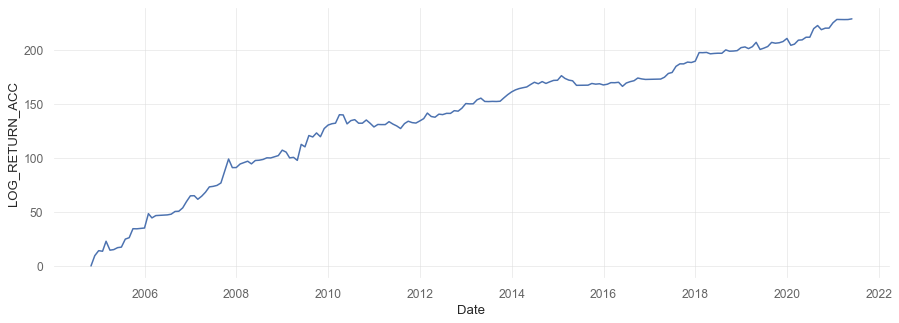

In [17]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['LOG_RETURN_ACC'])

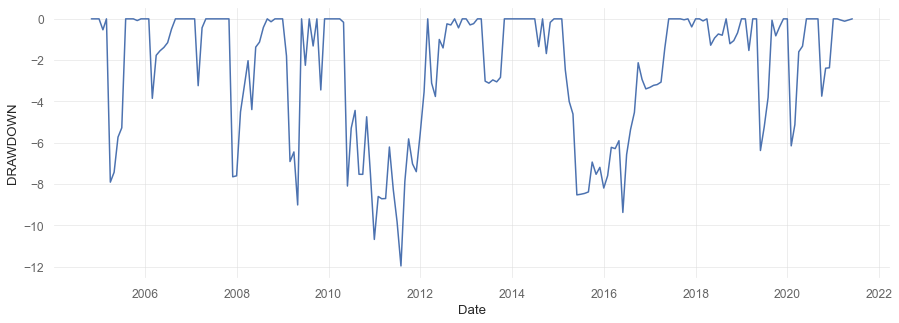

In [18]:
plt.figure(figsize=(15,5))
seaborn.lineplot(data=df_asset, x=df_asset.index, y=df_asset['DRAWDOWN'])

아래 그림의 샤프 비율은 월간 데이터로 구해진 것이라 왜곡되어 있습니다. 환산시킨 1.22나 Return-Risk Ratio 1.24가 더 믿을 만 합니다.

In [19]:
quantstats.stats.sharpe(df_asset['RETURN'])/math.sqrt(252/12)

1.2201114376272868

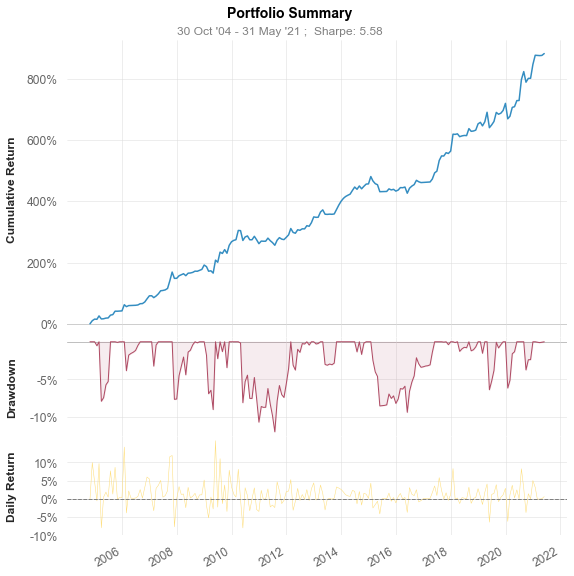

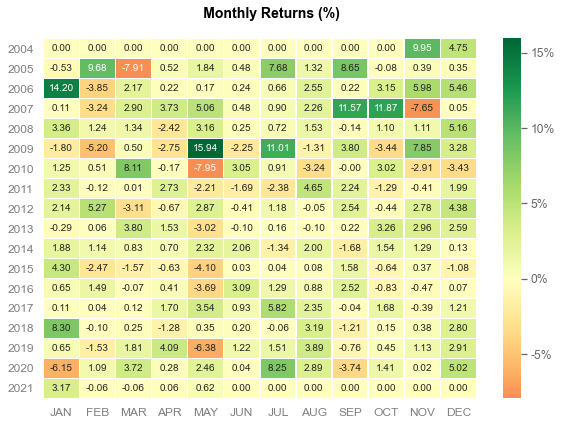

In [20]:
quantstats.reports.plots(df_asset['RETURN']/100, mode='basic')